# Self-Supervised Monocular Depth Estimation

## Abstract

#### Traditional image depth estimation approaches are mostly relied on structure from motion and multi-view stereo, where most of them require multiple viewpoints of the scene are available. There are a large number of recent stuides focus on removing such limitation by applying Machine Learning based method to perform munocular depth estimation.

#### In this project, we implemented one of the self-supervised single image depth estimation method based on the result from this paper: [Unsupervised Monocular Depth Estimation with Left-Right Consistency](https://arxiv.org/abs/1609.03677v3). It uses a CNN to learn to perform single image depth estimation, despite the absence of ground truth depth data.

## Team members and contribution

#### Yiran Cao
* contribution 1
* contribution 2

#### Haoyu Tian
* contribution 1
* contribution 2

#### Tengyu Cai
* contribution 1
* contribution 2

In [10]:
from mylibs.dataloader import KittiDataset
from mylibs.transformation import ToResizeImage, ToRandomFlip, ToTensor, AugumentImagePair
from mylibs.model import Model

import torch
from torch.utils.data import DataLoader

import os
import numpy as np
import random
import skimage.transform
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import torchvision.transforms.functional as tF

from skimage.metrics import structural_similarity as ssim

In [ ]:
USE_GPU = False

## Data Loading

#### We use the [KITTI driving dataset](http://www.cvlibs.net/datasets/kitti/raw_data.php) as our data for training and testing as what it used by the paper.

In [11]:
train_path = os.path.join(os.getcwd(), 'data/train')
test_path = os.path.join(os.getcwd(), 'data/test')

In [12]:
train_transform = transforms.Compose([
    ToResizeImage(),
    ToRandomFlip(),
    ToTensor(),
    AugumentImagePair(),
])
test_transform = transforms.Compose([
    ToResizeImage(),
    ToTensor(),
])

In [13]:
train_set = KittiDataset(train_path, 'train', transform = train_transform)
test_set = KittiDataset(test_path, 'test', transform = test_transform)

train_loader = DataLoader(train_set, batch_size = 5, shuffle = True)
test_loader = DataLoader(test_set, batch_size = 77, shuffle = False)

In [14]:
# for data in train_set:
#     left = data['left_image'][0]
#     right = data['right_image'][0]
#     ssim = ssim(left, right, data_range=right.max() - right.min(), multichannel=True)

## Implement CNN using PyTorch

<img src="images\model_architecture.png"> 

In [15]:
model = Model(train_loader=train_loader,
              test_loader=test_loader,
              device='cuda' if USE_GPU else 'cpu', 
              epochs=1, 
              save_per_epoch=10, 
              img_height=256, 
              img_width=512, 
              model_path='output_model', 
              disp_path='output_disp')

In [16]:
loss = model.train()

--- Epoch 0	Average Loss: 1.09	Time: 0:06:38.436037


FileNotFoundError: [Errno 2] No such file or directory: 'output_model/0.pt'

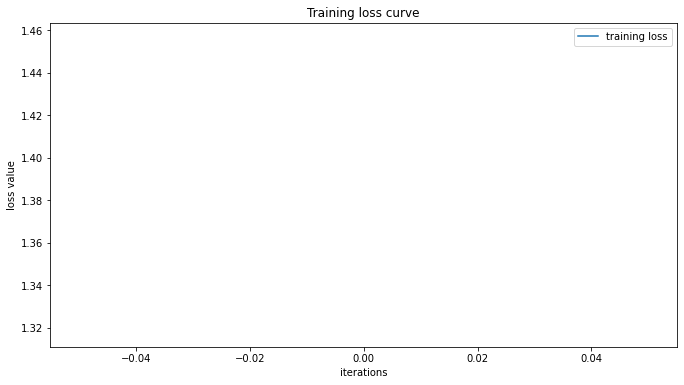

In [8]:
fig = plt.figure(figsize=(12,6)) 
plt.subplots_adjust(bottom=0.2,right=0.85,top=0.95) 
ax = fig.add_subplot(1,1,1)

loss = np.array(loss)

ax.clear() 
ax.set_xlabel('iterations')
ax.set_ylabel('loss value') 
ax.set_title('Training loss curve') 
ax.plot(loss, label='training loss') 
ax.legend(loc='upper right') 
fig.canvas.draw() 

In [9]:
model.test('output_model/0.pt')

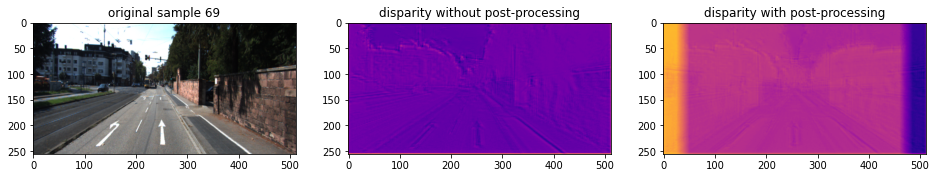

In [10]:
# plot original image, disparity, and disparity with post-processing
test_size = len(test_loader.dataset)

for data in test_loader:
    idx = random.randint(0, len(data['left_image']))
    img = data['left_image'][idx].permute(1,2,0)

disp = np.load('output_disp/disparities.npy')
disp_pp = np.load('output_disp/disparities_pp.npy')

disp_to_img = skimage.transform.resize(disp[idx].squeeze(), [256, 512], mode='constant')
disp_pp_to_img = skimage.transform.resize(disp_pp[idx].squeeze(), [256, 512], mode='constant')

fig = plt.figure(figsize=(16, 12))

ax = fig.add_subplot(1,3,1)
plt.title('original sample ' + str(idx))
plt.imshow(img, cmap='plasma')

ax = fig.add_subplot(1,3,2)
plt.title('disparity without post-processing')
plt.imshow(disp_to_img, cmap='plasma')

ax = fig.add_subplot(1,3,3)
plt.title('disparity with post-processing')
plt.imshow(disp_pp_to_img, cmap='plasma')